In [1]:
import tensorflow as tf 
print(tf.__version__)

2.3.0


In [2]:
import tensorflow_hub as hub
mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"



In [3]:
mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 
model = tf.keras.Sequential([ hub.KerasLayer(handle = mobile_net_url, input_shape = (224, 224, 3)) ]) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [ ]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2() 
tf.keras.utils.plot_model(mobilev2)

In [5]:
import os 
import pathlib
#기본 경로설정 
content_data_url = '/content/sample_data'
#데이터 불러오기 
data_root_orig = tf.keras.utils.get_file(fname = 'imagenetV2', origin ='https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz', cache_dir=content_data_url, extract=True)
#데이터 저장 경로 설정 
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-top-images-format-val') 
print(data_root)


1234968576/1234964480 [==============================] - 12s 0us/step
/content/sample_data/datasets/imagenetv2-top-images-format-val


In [10]:
#라벨 정보 불러오기 
label_file = tf.keras.utils.get_file(fname='label', origin='https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

#빈 객체 생성 
label_text = None 
#text파일 열고 '읽기모드' 설정 
with open(file = label_file, mode = 'r') as f: 
#[:-1] 처음부터 끝까지 읽기. 구분 기준 '\n' #라벨 정보 불러오기 
  label_file = tf.keras.utils.get_file(fname='label', origin='https://storage.googleapis.com/ download.tensorflow.org/data/ImageNetLabels.txt') 


#빈 객체 생성 
  label_text = None
#text파일 열고 '읽기모드' 설정 
  with open(file = label_file, mode = 'r') as f: 
#[:-1] 처음부터 끝까지 읽기.'\n' 줄바꿈 기준으로 나눔(split) 
    label_text = f.read().split('\n')[:-1]
print(len(label_text)) 
print(label_text[:10]) 
print(label_text[-10:])


1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


In [11]:
import PIL.Image as Image 
import matplotlib.pyplot as plt 
import random
#listdir은 해당 경로의 파일/디렉터리 이름만 가져오지만, #glob의 경우는 탐색한 경로까지 함께 가져온다. # '*/*'모든 경로 및 파일 
all_image_paths = list(data_root.glob('*/*')) 
# 위의 모든 경로 및 파일명을 문자화 시켜서 변수에 할당 
all_image_paths = [str(path) for path in all_image_paths] 
# 이미지를 랜덤하게 섞습니다. 
random.shuffle(all_image_paths)
#이미지의 총 수 확인 
image_count = len(all_image_paths) 
print('image_count:', image_count)


# 1000 개의 카테고리 x 10 개씩

image_count: 10000


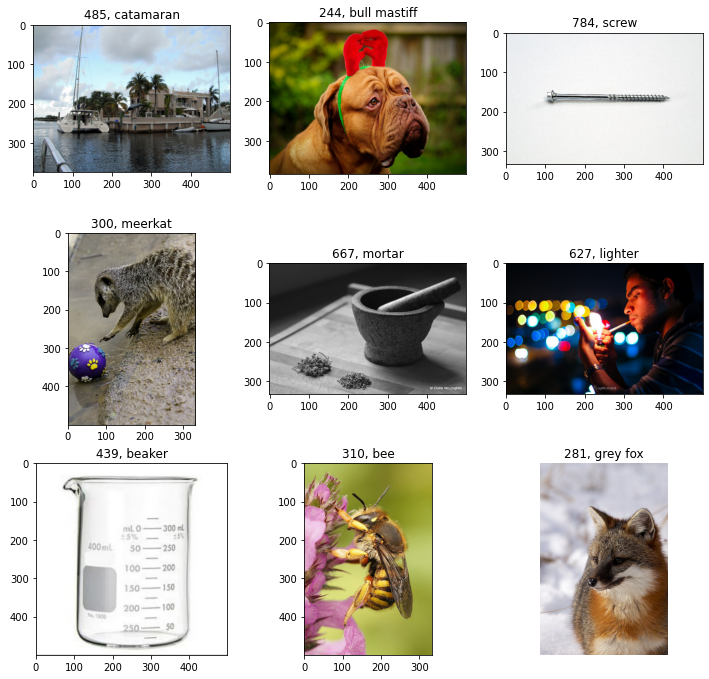

In [16]:
plt.figure(figsize=(12,12))
for i in range(9): 
  #이미지를 랜덤으로 추출 
  image_path = random.choice(all_image_paths) 
  #차례로 출력 
  plt.subplot(3,3,i+1) 
  #plt.imshow() : 이미지 출력 
  #plt.imread() : 파일 읽어오기 
  # 랜덤으로 선택된 사진 출력 
  plt.imshow(plt.imread(image_path))
  #첫 번째 부터 1000번째 까지의 라벨과 텍스트가 동일한 값을 갖도록 코딩 
  idx = int(image_path.split('/')[-2]) + 1
  #각 사진마다 라벨링 번호 + 라벨 텍스트 출력 
  plt.title(str(idx) + ', ' + label_text[idx])
#픽셀 크기를 나타내는 축 제거('off') 
plt.axis('off') 
plt.show()

In [32]:
import cv2 
import numpy as np
#빈 객체 생성 
top_1 = 0 
top_5 = 0
# all_image_paths에 저장되어 있는 경로를 하나씩 불러오며 반복 

for image_path in all_image_paths[:]: 
  #cv2.imread() : 사진 읽어들이기 
  img = cv2.imread(image_path) 

  #cv2.resize() : 사진 크기 재조정 (픽셀 통일) 
  img = cv2.resize(img, dsize=(224, 224)) 

  # 최소 최대 정규화 
  img = img / 255.0 

  #np.expand_dims( axis = 0 ) : 첫 번째 차원 추가 → 배치 추가 #(224,224,3) → (1,224,224,3) 
  img = np.expand_dims(img, axis=0)
  #예측값에 대한 순위 정보[0]를, argsort()로 index 정렬 (sotfmax를 통과한 값을 바탕으로 '순위(index)' 정렬) 
  #[::-1] Extended Slices 기법으로 내림차순으로 변경, [:5] 그 중 top 5개 
  top_5_predict = model.predict(img)[0].argsort()[::-1][:5] 

  #라벨링 번호 도출 
  idx = int(image_path.split('/')[-2])+1
  #신경망은 반복문을 타고 넘어온 n번째 img를 가지고 예측을 수행해서 5개의 TOP 후보(top_5_predict)를 추렸습니다. 
  #만약 이 n번째 img가 신경망이 가장 높게 예측한 후보 5개 안에 들어있다면은, 
  if idx in top_5_predict: 
  # top_5 에 1 추가 
    top_5 += 1 
  # 또 만약에 가장 높게 예측한 것[0]과 idx과 같다면은 
    if top_5_predict[0] == idx: 
    #top_1 에 1을 추가 
      top_1 += 1

In [33]:

#최종 출력 
# 정확하게 예측한 경우 / 전체 사진 수 
print('TOP - 5 정확성 :', top_5 / len(all_image_paths) * 100, '%') 
print('TOP - 1 정확성 :', top_1 / len(all_image_paths) * 100, '%') 

TOP - 5 정확성 : 83.3 %
TOP - 1 정확성 : 58.76 %
